In [1]:
import jax
import jax.numpy as jnp
from solarcarsim.physsim import CarParams, fractal_noise_1d
from solarcarsim.simv2 import Snax, SimParams
import chex


key = jax.random.key(0)

slope = fractal_noise_1d(key, 10000, scale=1200, height_scale=0.08)

slope

Array([ 0.0000000e+00, -2.5544850e-07, -1.4012958e-06, ...,
       -1.1142221e-02, -1.1067827e-02, -1.1001030e-02], dtype=float32)

In [2]:
# make a simple triangle-type hill. Slope is 0.2 and then -0.2
dist = 1000 # it's 1 km long
xcoords = jnp.arange(dist)
slope = jnp.concat([jnp.full(int(dist/2), 0.2), jnp.full(int(dist/2), -0.2)])
def lerp(x):
    return jnp.interp(x, xcoords, slope)

In [3]:
time_scale = 0.1


In [4]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper


class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env

    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)


class VecEnv(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.reset = jax.vmap(self._env.reset, in_axes=(0, None))
        self.step = jax.vmap(self._env.step, in_axes=(0, 0, 0, None))

class ClipAction(GymnaxWrapper):
    def __init__(self, env, low=-1.0, high=1.0):
        super().__init__(env)
        self.low = low
        self.high = high

    def step(self, key, state, action, params=None):
        """TODO: In theory the below line should be the way to do this."""
        # action = jnp.clip(action, self.env.action_space.low, self.env.action_space.high)
        action = jnp.clip(action, self.low, self.high)
        return self._env.step(key, state, action, params)



class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env = Snax()
    env_params = env.default_params
    env = LogWrapper(env)
    env = VecEnv(env)
    #env = ClipAction(env)
    # if config["NORMALIZE_ENV"]:
    #     env = NormalizeVecObservation(env)
    #     env = NormalizeVecReward(env, config["GAMMA"])

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).shape[0], activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = env.reset(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = env.step(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):

                def callback(info):
                    return_values = info["returned_episode_returns"][
                        info["returned_episode"]
                    ]
                    timesteps = (
                        info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    )
                    for t in range(len(timesteps)):
                        print(
                            f"global step={timesteps[t]}, episodic return={return_values[t]}"
                        )

                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        metrics = []
        for i in range(config["NUM_MAINLOOPS"]):
            runner_state, metric = jax.lax.scan(
                _update_step, runner_state, None, config["NUM_UPDATES"]
            )
            metrics.append(metric)
        return {"runner_state": runner_state, "metrics": metrics}

    return train


In [5]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 2048,
    "NUM_STEPS": 10,
    "TOTAL_TIMESTEPS": 5e7,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 64,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "hopper",
    "ANNEAL_LR": False,
    "NORMALIZE_ENV": True,
    "DEBUG": False,
    "NUM_MAINLOOPS": 3,
}
config_light = {
    "LR": 3e-4,
    "NUM_ENVS": 128,
    "NUM_STEPS": 10,
    "TOTAL_TIMESTEPS": 5e3,
    "UPDATE_EPOCHS": 2,
    "NUM_MINIBATCHES": 16,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "hopper",
    "ANNEAL_LR": False,
    "NORMALIZE_ENV": True,
    "DEBUG": False,
}

rng = jax.random.key(42)
train_jit = jax.jit(make_train(config))
out = train_jit(rng)

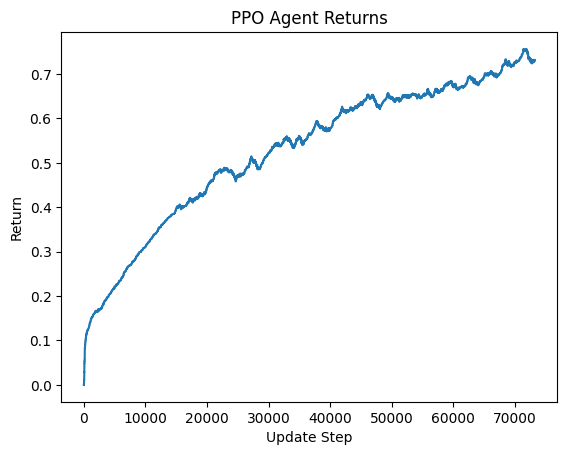

In [15]:
import matplotlib.pyplot as plt
data = jnp.concatenate([out["metrics"][x]["returned_episode_returns"].mean(-1).reshape(-1) for x in range(3)])
plt.plot(data)
ax = plt.gca()

plt.xlabel("Update Step")
plt.ylabel("Return")
plt.title("PPO Agent Returns")
plt.savefig("PPO_results.pdf")
plt.show()

In [19]:
tstate = out['runner_state'][0]
lastobs = out['runner_state'][2]
# tstate.apply_fn(tstate.params, lastobs)

env = Snax()
env_params = env.default_params
env = LogWrapper(env)
env = VecEnv(env)

def _env_step(runner_state, unused):
    train_state, env_state, last_obs, rng = runner_state

    # SELECT ACTION
    rng, _rng = jax.random.split(rng)
    pi, value = train_state.apply_fn(train_state.params, last_obs)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)

    # STEP ENV
    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, config["NUM_ENVS"])
    obsv, env_state, reward, done, info = env.step(
        rng_step, env_state, action, env_params
    )
    transition = Transition(
        done, action, value, reward, log_prob, last_obs, info
    )
    runner_state = (train_state, env_state, obsv, rng)
    return runner_state, env_state



runner_state, env_logs = jax.lax.scan(
    _env_step, out['runner_state'], None, 100
)

2024-12-17 20:40:06.756483: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.63GiB (rounded to 8192000000)requested by op 
2024-12-17 20:40:06.756558: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ***************************************************_________________________________________________
E1217 20:40:06.756588  512196 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8192000000 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8192000000 bytes.

In [8]:
out['runner_state'][0]

TrainState(step=Array(1874688, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of ActorCritic(
    # attributes
    action_dim = 1
    activation = 'tanh'
)>, params={'params': {'Dense_0': {'bias': Array([-5.3029938e-04,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        1.9191748e-03,  0.0000000e+00, -1.7144637e-04,  2.5281330e-05,
        1.4641370e-03,  0.0000000e+00, -1.3245111e-03,  0.0000000e+00,
        0.0000000e+00,  8.3523680e-04,  0.0000000e+00,  0.0000000e+00,
        6.0847404e-05, -4.7602013e-04,  0.0000000e+00,  1.3794134e-03,
        0.0000000e+00, -7.6553306e-06,  0.0000000e+00,  2.1930558e-04,
        0.0000000e+00, -2.2188693e-03,  1.4511290e-03,  1.9425271e-03,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.1256059e-03,
       -5.8398215e-04,  0.0000000e+00, -1.8540439e-03,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
   

In [9]:
import orbax.checkpoint
from flax.training import orbax_utils
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
ckpt = {'model': out['runner_state'][0]}
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('/tmp/flax_ckpt/orbax/single_save', ckpt, save_args=save_args)

ValueError: Destination /tmp/flax_ckpt/orbax/single_save already exists.